In [1]:
import zipfile
from matplotlib import pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!wget -O Sherlock.txt https://www.gutenberg.org/ebooks/48320.txt.utf-8
!unzip wiki-news-300d-1M.vec.zip

--2023-11-02 04:06:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.39.25, 13.249.39.6, 13.249.39.82, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.39.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   197MB/s    in 3.4s    

2023-11-02 04:06:18 (192 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

--2023-11-02 04:06:19--  https://www.gutenberg.org/ebooks/48320.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.gutenberg.org/cache/epub/48320/pg48320.txt [following]
--2023-11

In [3]:
with open("Sherlock.txt", 'r', encoding='utf-8') as file:
    book = file.read()

In [4]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|no|No)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def split_into_sentences(text: str) -> list[str]:
    """
    Split the text into sentences.

    If the text contains substrings "<prd>" or "<stop>", they would lead
    to incorrect splitting because they are used as markers for splitting.

    :param text: text to be split into sentences
    :type text: str

    :return: list of sentences
    :rtype: list[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = ['<SOS> ' + s.strip() + ' <EOS>' for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences

In [5]:
book = split_into_sentences(book)

In [6]:
book[1000:1002]

['<SOS> I had come to the conclusion that he had dropped asleep, and indeed was nodding myself, when he suddenly sprang out of his chair with the gesture of a man who has made up his mind, and put his pipe down upon the mantel-piece. <EOS>',
 '<SOS> “Sarasate plays at the St. James’s Hall this afternoon,” he remarked. <EOS>']

In [7]:
maxTokens = 5000
token = Tokenizer(num_words=maxTokens,
                  filters='!"“”#$%&()*+,.-/:;=?@[\\]^_`{|}~\t\n\ufeff\u2002', lower=True,
                  split=' ', char_level=False, oov_token=None)
token.fit_on_texts(book)

In [8]:
sequences = token.texts_to_sequences(book)

In [9]:
maxLen = len(max(sequences, key=len))

In [10]:
maxLen

153

In [11]:
def create_dataset(sequence):
    inputs = []
    outputs = []
    for i, sent in enumerate(sequence):
        for j in range(1, len(sent)-1):
          inputs.append(sent[:j])
          outputs.append([sent[j]])

    return inputs, outputs

In [12]:
X, y = create_dataset(sequences)
x_train = pad_sequences(X, maxlen=maxLen)
y_train = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

In [13]:
token.sequences_to_texts([X[20]])

['<sos> the project gutenberg ebook of adventures of sherlock holmes this ebook is for the use of anyone anywhere in the']

In [14]:
reverse_dictionary = token.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])
num_words=len(dictionary)+1

In [15]:
import codecs
import IPython.display as ipd
from IPython.display import Audio, update_display
from ipywidgets import IntProgress

EMB = "wiki-news-300d-1M.vec"
N = 1000000

#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(f'./{EMB}', encoding='utf-8')
bar = IntProgress(min=0, max=N)
ipd.display(bar)

i = 0
for n, line in enumerate(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    if n//(N//100) > i:
          bar.value = n
          i += 1
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


IntProgress(value=0, max=1000000)

found 999995 word vectors


In [17]:
embed_dim=300
embedding_matrix=np.zeros([num_words, embed_dim])
for word, idx in dictionary.items():
  if word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

In [18]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply, Lambda, Flatten, Activation, Reshape, BatchNormalization, GRU, SimpleRNN
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

nb_words = len(embedding_matrix) #Vocabulary size
embed_dim = len(embedding_matrix[0]) #Vectorization dim
value_dim = 50
maxLen = len(x_train[0])

In [97]:
input_layer = Input(shape=(maxLen,)) #Cantidad maxima de la frase de entrada, estos son los timesteps para este caso
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True)(input_layer)
lstm = LSTM(value_dim, return_sequences=False, activation="tanh")(embedding_layer)
drop = Dropout(0.4)(lstm)
dense3 = Dense(100, activation='relu')(drop)
drop3 = Dropout(0.4)(dense3)
dense4 = Dense(nb_words, activation='softmax')(drop3)
model = Model(inputs=input_layer, outputs=dense4)

In [32]:
model2 = tf.keras.Sequential()
model2.add(Input(shape=(maxLen,)))
model2.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True))
model2.add(GRU(value_dim, return_sequences=False, activation="tanh"))
model2.add(Dropout(0.4))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(nb_words, activation='softmax'))

In [72]:
num_filters=12
model3 = tf.keras.Sequential()
model3.add(Input(shape=(maxLen,)))
model3.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True))
model3.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model3.add(MaxPooling1D(2))
model3.add(Conv1D(num_filters*2, 7, activation='relu', padding='same'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.4))
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(nb_words, activation='softmax'))

In [88]:
model4 = tf.keras.Sequential()
model4.add(Input(shape=(maxLen,)))
model4.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True))
model4.add(SimpleRNN(value_dim, return_sequences=False, activation="tanh"))
model4.add(Dropout(0.4))
model4.add(Dense(100, activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(nb_words, activation='softmax'))

In [73]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 153)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 153, 300)          2652900   
                                                                 
 lstm_2 (LSTM)               (None, 50)                70200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 100)               5100      
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 8843)              8931

In [74]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 153, 300)          2652900   
                                                                 
 gru_1 (GRU)                 (None, 50)                52800     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 100)               5100      
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 8843)              893143    
                                                                 
Total params: 3,603,943
Trainable params: 3,603,943
No

In [75]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 153, 300)          2652900   
                                                                 
 conv1d_5 (Conv1D)           (None, 153, 12)           25212     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 76, 12)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 76, 24)            2040      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 24)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_16 (Dropout)        (None, 24)               

In [89]:
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 153, 300)          2652900   
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                17550     
                                                                 
 dropout_18 (Dropout)        (None, 50)                0         
                                                                 
 dense_19 (Dense)            (None, 100)               5100      
                                                                 
 dropout_19 (Dropout)        (None, 100)               0         
                                                                 
 dense_20 (Dense)            (None, 8843)              893143    
                                                                 
Total params: 3,568,693
Trainable params: 3,568,693
No

In [76]:
callbackROP = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
callbackES = EarlyStopping(monitor='val_loss', patience=10)

In [98]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam')

In [99]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=512, epochs=50, callbacks=[callbackROP, callbackES])

Epoch 1/50
147/147 [==============================] - 25s 154ms/step - loss: 6.8098 - val_loss: 6.2542 - lr: 0.0010
Epoch 2/50
147/147 [==============================] - 11s 75ms/step - loss: 6.2211 - val_loss: 6.2263 - lr: 0.0010
Epoch 3/50
147/147 [==============================] - 10s 68ms/step - loss: 6.1546 - val_loss: 6.1531 - lr: 0.0010
Epoch 4/50
147/147 [==============================] - 8s 51ms/step - loss: 5.9972 - val_loss: 5.9230 - lr: 0.0010
Epoch 5/50
147/147 [==============================] - 6s 40ms/step - loss: 5.8043 - val_loss: 5.7841 - lr: 0.0010
Epoch 6/50
147/147 [==============================] - 6s 42ms/step - loss: 5.6731 - val_loss: 5.7128 - lr: 0.0010
Epoch 7/50
147/147 [==============================] - 5s 37ms/step - loss: 5.5758 - val_loss: 5.6589 - lr: 0.0010
Epoch 8/50
147/147 [==============================] - 6s 38ms/step - loss: 5.4921 - val_loss: 5.6229 - lr: 0.0010
Epoch 9/50
147/147 [==============================] - 6s 38ms/step - loss: 5.4233 - 

# Greedy search + ArgMax

In [37]:
def greedy_search(question, outputLen, model):

  out = 0
  response = []
  reply = question
  finished = False

  while out != token.texts_to_sequences(["<eos>"])[0][0] and len(response) < outputLen:
      out = pad_sequences(reply, maxlen=maxLen)
      out = model.predict(out, verbose=0)
      out = int(np.argmax(out))
      reply[0] += [out]
      response.append(out)

  return response

In [38]:
question = token.texts_to_sequences(["<sos> sherlock"])

In [92]:
def from_seq_to_text(seq):
    return token.sequences_to_texts([seq])

response = greedy_search(question, 15, model4)
rta = from_seq_to_text(response)
rta

['and i had been to me to be a little of the door of the']

# Greedy search + T

In [44]:
def changeTemp(a, temperature=1.0, epsilon=1e-10):
    a = np.log(a) / temperature
    sampled_temp = np.exp(a+1e-10)/(np.exp(a+1e-10).sum())
    sampled_temp = sampled_temp/sampled_temp.sum()
    return sampled_temp

In [45]:
def greedy_search_withT(question, model, max_len=15, T=1.0):

  out = 0
  response = []
  reply = question
  finished = False
  eof = token.texts_to_sequences(["<eos>"])[0][0]

  while out != eof and len(response) < max_len:

      out = pad_sequences(reply, maxlen=maxLen)
      out = model.predict(out, verbose=0)
      temp = changeTemp(out[0], temperature=T)
      out = np.random.choice(range(len(temp)), p=temp)
      reply[0] += [out]
      if out in response:
        finished = True
      else:
        response.append(out)

  return response

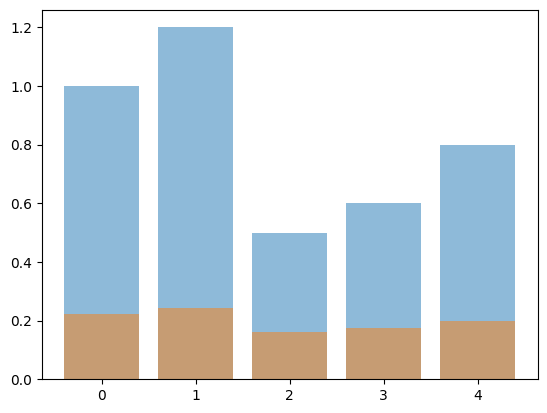

In [46]:
arr1 = [1, 1.2, 0.5, 0.6, 0.8]
plt.figure()
plt.bar(range(len(arr1)), arr1, alpha=0.5)
arr2 = changeTemp(arr1, temperature=2.1)
plt.bar(range(len(arr2)), arr2, alpha=0.5)
plt.show()

In [85]:
question = token.texts_to_sequences(["<sos> he ran"])

In [93]:
def from_seq_to_text(seq):
    return token.sequences_to_texts([seq])

response = greedy_search_withT(question, model4, max_len=15, T=1)
rta = from_seq_to_text(response)
rta

['house here as i had stretched up all your seemed for a first sound about']

# Stochastic beam search + T (most probable path)

In [56]:
def stoch_beam_search(kBeams, maxOutputLen, candidatesAndProb, T=1.0):

  candidates = candidatesAndProb[0]
  probabilities = candidatesAndProb[1]

  if maxOutputLen < 1:
    return candidates, probabilities
  else:

    possibleCand = [0]*kBeams
    possibleProb = [0]*kBeams

    #Calculamos los candidatos para cada rama, kBeams candidatos maximos
    for curr in candidates:
      out = pad_sequences([curr], maxlen=maxLen)
      out = model.predict(out, verbose=0) #Probabilidades
      temp = changeTemp(out[0], temperature=T)
      newCandidates = np.argsort(temp)[::-1][:kBeams] #Agarramos los indices de los k-elementos con mas prob
      newCandidates = [[num] for num in newCandidates] #Convertimos los numeros en listas de numeros por compatibilidad con pad_sequences
      newCandProba = [temp[i] for i in newCandidates] #Agarramos su probabilidad

      #Elegimos los kBeams caminos con mas probabilidad
      for i, prob in enumerate(newCandProba): #Agarramos la probabilidad de cada candidato
        for j in range(len(possibleProb)): #Para cada probabilidad maxima guardada
          if possibleProb[j] < prob and newCandProba[i] not in possibleCand:
            possibleProb[j] = prob
            possibleCand[j] = newCandProba[i]

    #print(possibleCand)
    #print(possibleProb)

    concatenated = np.concatenate((candidates, newCandidates), axis=1)
    probabilities = np.multiply(probabilities, newCandProba)

    #print(concatenated)
    #print(probabilities)

    return stoch_beam_search(kBeams, maxOutputLen-1, (concatenated, probabilities))

In [57]:
question = token.texts_to_sequences(["<sos> watson was walking"])

In [58]:
maxOutputLen = 10
kBeams = 5
candidates = (question*kBeams, 1*kBeams)

outSeq, outProb = stoch_beam_search(kBeams, maxOutputLen, candidates, T=1.1)
result = token.sequences_to_texts(outSeq)

for i, sent in enumerate(result):
  print(f"prob: {outProb[i][0]:.10f} - Rta: {sent}")

prob: 0.0000000000 - Rta: <sos> watson was walking in the man and the a very be been a
prob: 0.0000000000 - Rta: <sos> watson was walking from a room in a the a the a not
prob: 0.0000000000 - Rta: <sos> watson was walking and his house of my in in a not been
prob: 0.0000000000 - Rta: <sos> watson was walking to my little with his to and me the to
prob: 0.0000000000 - Rta: <sos> watson was walking into this face to be very to have be the


# Stochastic beam search + T (most probable candidate)

In [59]:
def beam_search(kBeams, maxOutputLen, candidatesAndProb, T=1.0):

  candidates = candidatesAndProb[0]
  probabilities = candidatesAndProb[1]

  if maxOutputLen < 1:
    return candidates, probabilities
  else:
    for curr in candidates:
      out = pad_sequences([curr], maxlen=maxLen)
      out = model.predict(out, verbose=0) #Probabilidades
      temp = changeTemp(out[0], temperature=T)
      newCandidates = np.argsort(temp)[::-1][:kBeams] #Agarramos los indices de los k-elementos con mas prob
      newCandidates = [[num] for num in newCandidates] #Convertimos los numeros en listas de numeros por compatibilidad con pad_sequences
      newCandProba = [temp[i] for i in newCandidates] #Agarramos su probabilidad

      concatenated = np.concatenate((candidates, newCandidates), axis=1)
      probabilities = np.multiply(probabilities, newCandProba)

      return beam_search(kBeams, maxOutputLen-1, (concatenated, probabilities))

In [60]:
question = token.texts_to_sequences(["<sos> watson was walking"])

In [61]:
maxOutputLen = 10
kBeams = 5
candidates = (question*kBeams, 1*kBeams)

outSeq, outProb = beam_search(kBeams, maxOutputLen, candidates, T=1.1)
result = token.sequences_to_texts(outSeq)

for i, sent in enumerate(result):
  print(f"prob: {outProb[i][0]:.10f} - Rta: {sent}")

prob: 0.0000000000 - Rta: <sos> watson was walking in the man and i have been a very man
prob: 0.0000000000 - Rta: <sos> watson was walking from a room of you am not not little little
prob: 0.0000000000 - Rta: <sos> watson was walking and his little in he had a to man very
prob: 0.0000000000 - Rta: <sos> watson was walking to my house but it think to very matter matter
prob: 0.0000000000 - Rta: <sos> watson was walking into this very who the was no the other room


In [142]:
def perplexity_old(model, init_seq, length):
  seq = init_seq
  score = 1
  for i in range(length):
    out = pad_sequences(seq, maxlen=maxLen)
    out = model.predict(out, verbose=0)
    argmax = np.argmax(out[0])
    seq = [np.concatenate([seq[0], [argmax]])]
    print(seq)
    score *= (1/out[0][argmax])**(1/length)
  return score

def perplexity(model, init_seq):
  seq = init_seq
  score = 1
  for i in range(2, len(seq[0])):
    out = pad_sequences([seq[0][:i]], maxlen=maxLen)
    out = model.predict(out, verbose=0)
    score *= (1/out[0][seq[0][i]])**(1/len(seq[0]))
  return score

In [143]:
question = token.texts_to_sequences(["<sos> sherlock holmes was a detective"])
print(question)
score = perplexity(model, question)

score

[[1, 123, 36, 14, 8, 1563]]


10.561373474310626